In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### 1. Bộ dữ liệu ARE Historical Data

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARE-Historical-Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 4s 36ms/step - loss: 0.1118 - val_loss: 0.3850
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0703
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.0177 - val_loss: 0.0967
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0124 - val_loss: 0.0380
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0079
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 5.7854e-04 - val_loss: 0.0148
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 4.7732e-04 - val_loss: 0.0100
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 4.4943e-04 - val_loss: 0.0083
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 4.3104e-04 - val_loss:

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 1ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [13]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 2.7376903074727363
Testing RMSE: 3.1590826444306233
Testing MAE: 2.50209716796875
Validation MAE: 2.0895327082220114
Testing MAPE: 1.3496201723697994
Validation MAPE: 1.4918068589284856


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.2903731]
2
1 day input [0.29037309]
1 day output [[0.29244283]]
2 day input [0.29244283]
2 day output [[0.29451886]]
3 day input [0.29451886]
3 day output [[0.29660118]]
4 day input [0.29660118]
4 day output [[0.29868987]]
5 day input [0.29868987]
5 day output [[0.3007849]]
6 day input [0.30078489]
6 day output [[0.30288625]]
7 day input [0.30288625]
7 day output [[0.304994]]
8 day input [0.30499399]
8 day output [[0.30710796]]
9 day input [0.30710796]
9 day output [[0.3092283]]
10 day input [0.3092283]
10 day output [[0.31135494]]
11 day input [0.31135494]
11 day output [[0.31348786]]
12 day input [0.31348786]
12 day output [[0.315627]]
13 day input [0.31562701]
13 day output [[0.31777233]]
14 day input [0.31777233]
14 day output [[0.3199238]]
15 day input [0.31992379]
15 day output [[0.3220814]]
16 day input [0.32208139]
16 day output [[0.32424492]]
17 day input [0.32424492]
17 day output [[0.32641444]]
18 day input [0.32641444]
18 day output [[0.3285898]]
19 day input [0.3285898]

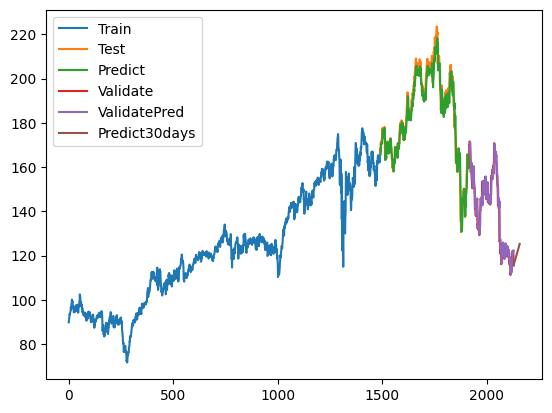

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 2. Bộ dữ liệu ARI Historical Data

In [16]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data.csv')
df1=df.reset_index()['Price']

In [17]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [19]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [22]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 4s 38ms/step - loss: 0.5999 - val_loss: 0.2392
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2803 - val_loss: 0.0052
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0220 - val_loss: 0.0123
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0210
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0151
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0122
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0106
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0089
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 11

In [24]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 1ms/step


In [25]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [26]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [27]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.29190573134276376
Testing RMSE: 0.28246476055202097
Testing MAE: 0.2265944080938968
Validation MAE: 0.21313384973777919
Testing MAPE: 1.6873668291562536
Validation MAPE: 2.005128125113385


In [28]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.45111924]
2
1 day input [0.45111924]
1 day output [[0.4446613]]
2 day input [0.44466129]
2 day output [[0.43852848]]
3 day input [0.43852848]
3 day output [[0.43271935]]
4 day input [0.43271935]
4 day output [[0.4272304]]
5 day input [0.42723039]
5 day output [[0.42205596]]
6 day input [0.42205596]
6 day output [[0.4171889]]
7 day input [0.41718891]
7 day output [[0.41262054]]
8 day input [0.41262054]
8 day output [[0.40834108]]
9 day input [0.40834108]
9 day output [[0.40433973]]
10 day input [0.40433973]
10 day output [[0.40060505]]
11 day input [0.40060505]
11 day output [[0.3971251]]
12 day input [0.3971251]
12 day output [[0.3938874]]
13 day input [0.3938874]
13 day output [[0.39087963]]
14 day input [0.39087963]
14 day output [[0.38808915]]
15 day input [0.38808915]
15 day output [[0.38550362]]
16 day input [0.38550362]
16 day output [[0.3831107]]
17 day input [0.3831107]
17 day output [[0.3808986]]
18 day input [0.38089859]
18 day output [[0.37885562]]
19 day input [0.3788556

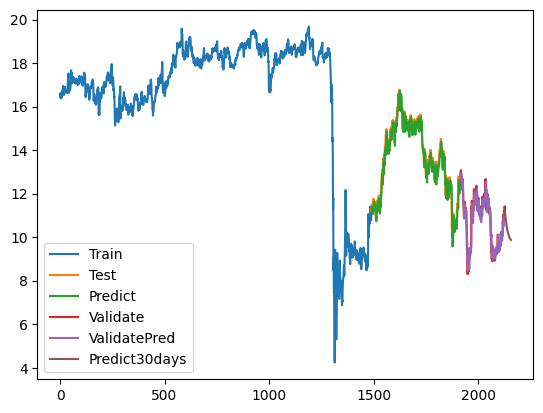

In [29]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 3. Bộ dữ liệu MAA Historical Data

In [30]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data.csv')
df1=df.reset_index()['Price']

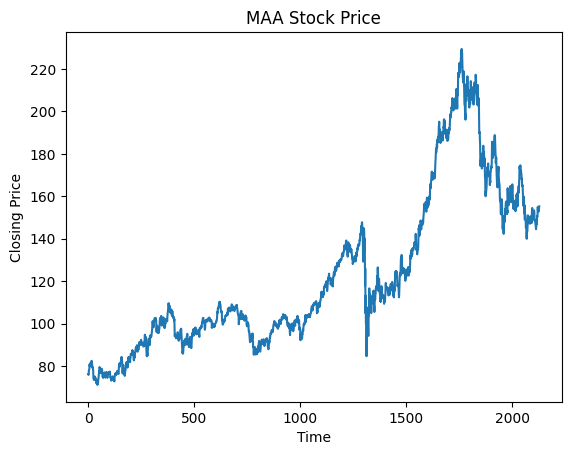

In [31]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [32]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [33]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [34]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [35]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [36]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [37]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [38]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 4s 36ms/step - loss: 0.0328 - val_loss: 0.3260
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.1858
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.1796
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.1131
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0133
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 5.6079e-04 - val_loss: 0.0343
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0478e-04 - val_loss: 0.0237
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 1.7589e-04 - val_loss: 0.0176
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 1.7121e-04 - val_loss: 0.0181
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 1.6616e-04 - val_l

In [39]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [40]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [41]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [42]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 2.7057596528060635
Testing RMSE: 3.6037177676180407
Testing MAE: 2.6930731504183276
Validation MAE: 2.1382996872236135
Testing MAPE: 1.4397791176249062
Validation MAPE: 1.3654876765054127


In [43]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.53723097]


2
1 day input [0.53723097]
1 day output [[0.54269]]
2 day input [0.54268998]
2 day output [[0.5479323]]
3 day input [0.54793233]
3 day output [[0.5529581]]
4 day input [0.55295807]
4 day output [[0.5577685]]
5 day input [0.55776852]
5 day output [[0.5623655]]
6 day input [0.56236547]
6 day output [[0.5667518]]
7 day input [0.56675178]
7 day output [[0.57093096]]
8 day input [0.57093096]
8 day output [[0.5749071]]
9 day input [0.57490712]
9 day output [[0.578685]]
10 day input [0.57868499]
10 day output [[0.58226997]]
11 day input [0.58226997]
11 day output [[0.58566743]]
12 day input [0.58566743]
12 day output [[0.58888346]]
13 day input [0.58888346]
13 day output [[0.5919242]]
14 day input [0.59192419]
14 day output [[0.5947963]]
15 day input [0.5947963]
15 day output [[0.5975061]]
16 day input [0.59750611]
16 day output [[0.60006046]]
17 day input [0.60006046]
17 day output [[0.60246587]]
18 day input [0.60246587]
18 day output [[0.60472906]]
19 day input [0.60472906]
19 day output 

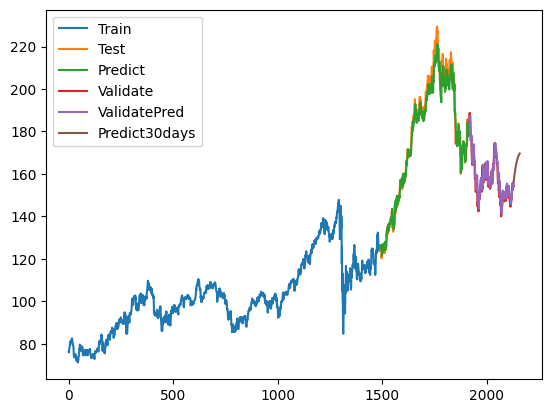

In [44]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()